# DSM Example
## import

In [9]:
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import register_matplotlib_converters

#register matplotlib converters which have been overwritten by pandas
register_matplotlib_converters()

In [10]:
from oemof import solph, outputlib
from oemof.network import Node

# plotting tools
import plotting as plt_dsm


## Energy Model
    source   - costs
- Coal PP    - 10
- Wind PP    - 0
- PV PP      - 0
- DSM        - 0
- excess     - 1
- shortage   - 200


In [11]:
# Create oemof model
def create_model(data, datetimeindex, directory, project, method):
    

    # ----------------- Energy System ----------------------------
    
    # Create Energy System
    es = solph.EnergySystem(timeindex=datetimeindex)
    Node.registry = es

    # Create Busses
    b_coal_1 = solph.Bus(label='bus_coal_1')
    b_elec = solph.Bus(label='bus_elec')

    # Create Sources
    s_coal_p1 = solph.Source(label='source_coal_p1',
                             outputs={
                                b_coal_1: solph.Flow(
                                    nominal_value=10000,
                                    variable_costs=10)}
                             )

    s_wind = solph.Source(label='wind',
                          outputs={
                              b_elec: solph.Flow(
                                  actual_value=data['wind'][datetimeindex],
                                  fixed=True,
                                  nominal_value=1)}
                          )

    s_pv = solph.Source(label='pv',
                        outputs={
                            b_elec: solph.Flow(
                                actual_value=data['pv'][datetimeindex],
                                fixed=True,
                                nominal_value=1)}
                        )

    # Create Transformer
    cfp_1 = solph.Transformer(label='pp_coal_1',
                              inputs={b_coal_1: solph.Flow()},
                              outputs={
                                  b_elec: solph.Flow(
                                      variable_costs=0)},
                              conversion_factors={b_elec: 1}
                              )

    # Create DSM
    demand_dsm = solph.custom.SinkDSM(label='demand_dsm',
                                inputs={b_elec: solph.Flow(variable_costs=2)},
                                demand=data['demand_el'][datetimeindex],
                                capacity_up=data['cap_up'][datetimeindex],
                                capacity_down=data['cap_do'][datetimeindex],
                                method=method,
                                delay_time=12,
                                shift_interval=24,
                                cost_dsm_up = 0,
                                cost_dsm_down = 0
                                )

    # Backup excess / shortage
    excess = solph.Sink(label='excess_el',
                        inputs={b_elec: solph.Flow(variable_costs=1)}
                        )

    s_shortage_el = solph.Source(label='shortage_el',
                                 outputs={
                                     b_elec: solph.Flow(
                                         variable_costs=200)}
                                 )

    # -------------------------- Create Model ----------------------

    # Create Model
    model = solph.Model(es)

    # Solve Model
    model.solve(solver='cbc', solve_kwargs={'tee': False})

    # Write LP File
    filename = os.path.join(os.path.dirname('__file__'), directory, project +'.lp')
    model.write(filename, io_options={'symbolic_solver_labels': True})

    # Save Results
    es.results['main'] = outputlib.processing.results(model)
    es.dump(dpath=None, filename=None)

    return model

## two different examples:
 - aggregation example:
    compares different household aggregation levels 1HH, 10HH, 50HH @ 1000kWH/year
 - methods example:
    compares the two different methods of SinkDSM: interval & delay

In [12]:
# ################################################################
# ----------------- Define Presets ----------------------------


# choose example
#project = 'aggregation'
project = 'methods'

# set starting date
start_model = '2013-03-01 00:00:00+0100'


# set time range for model
#timesteps_model = 'all'
timesteps_model = 24 * 7
#timesteps_model = '2013-03-03 00:00:00'

# Model

In [13]:


# ################################################################
# ----------------- Timesteps -----------------------
print('Model begins at:')
print(start_model)

if timesteps_model == 'all':
    print('test')
    print(timesteps_model)
    #timesteps_model = data.index.size
elif isinstance(timesteps_model, int):
    print('ends after {} timesteps'.format(timesteps_model))
elif isinstance(timesteps_model, str):
    print('end at:')
    print(timesteps_model)

    
# ----------------- Input Data  ----------------------

# output file
dict_df_model = {}
# input_directory
input_directory = 'data/{}/'.format(project)
# input_files
input_files = []
path = os.getcwd() + '/' + input_directory
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            input_files.append(file)
input_files.sort()

# loop all files in input directory
for input_file in input_files:

    for method in ['interval', 'delay']:
        folder = input_directory + input_file
        filename_data = os.path.join(os.path.dirname('__file__'), folder)
        
        # import Data
        data = pd.read_csv(filename_data,
                           sep=";",
                           decimal=',',
                           encoding='utf-8',
                           parse_dates=True,
                           date_parser=pd.to_datetime)
        data.sort_index(inplace=True)

        tz = 'Europe/Berlin'
        data.set_index('timestamp', inplace=True)
        data.index = pd.to_datetime(data.index, utc=True).tz_convert(tz)
        
        # Adjust Timesteps
        start_model = pd.to_datetime(start_model, utc=True).tz_convert(tz)
        
        if isinstance(timesteps_model, str):
            if timesteps_model == 'all':
                timesteps_model_in = data.index[-1]
            else:
                timesteps_model_in = timesteps_model
                
            datetimeindex = pd.date_range(start=start_model,
                                          end=timesteps_model_in, freq='H', tz=tz)

        else:
            timesteps_model_in = timesteps_model
            datetimeindex = pd.date_range(start=start_model,
                                          periods=timesteps_model, freq='H', tz=tz)

# ----------------- Create & Solve Model  ----------------------

        model = create_model(data, datetimeindex, input_directory, project, method)

        # Get Results
        es = solph.EnergySystem()
        es.restore(dpath=None, filename=None)

        # extract Data from model
        df_model = plt_dsm.extract_results(model)
        df_model.index = pd.to_datetime(datetimeindex, utc=True).tz_convert(tz)
        #df_model.index = pd.to_datetime(df_model.index, utc=True).tz_convert(tz)
        
        # export Data to dict
        dict_df_model.update({'{}_{}'.format(method, input_file):df_model})
        
#         write Data in Csv
#         df_gesamt.to_csv('./{}_{}'.format(method, input_file),
#                          encoding='utf-8', sep=';', decimal=',')


Model begins at:
2013-03-01 00:00:00+0100
ends after 168 timesteps


# Plotting
## presets

In [14]:
# Presets
figure_size = (15,6)

# start of plot
start = datetimeindex[0]

# plotted time range
timesteps = 24 * 3 + 3 #*31


steps = pd.date_range(start, periods=timesteps, freq='H', tz = 'Europe/Berlin') # stepsize

filter_for='.csv'


plot_style = 'normal'


### 
color=['teal','goldenrod','grey','coral','olive','orchid', 'silver', 'seagreen', 'slateblue']
drawstyle= {'scientific':{'step':'pre','drawstyle':'steps-post'},'normal':{'step':None,'drawstyle':None }}
ds = drawstyle[plot_style]

tz = 'Europe/Berlin'
#steps =pd.date_range(start, periods=timesteps, freq='H', tz=tz)
end = steps[-1]

# Info
print('start: {}'.format(start))
print('end:   {}'.format(end))
print('Files plotted:')
print([keys for keys in dict_df_model.keys() if filter_for in keys])


start: 2013-03-01 00:00:00+01:00
end:   2013-03-04 02:00:00+01:00
Files plotted:
['interval_scaled_data_2.csv', 'delay_scaled_data_2.csv']


In [15]:
df_data = dict_df_model
# show annual total 
dsm = pd.DataFrame()

for index, df in df_data.items():
    if filter_for in index:
        dsm[index[:-4]]  =df.abs().sum().round()
        dsm.loc['gen_total', index[:-4],] = df[['wind', 'pv', 'coal1']].sum().sum().round()
        dsm.loc['gen_EE', index[:-4]] = df[['wind', 'pv']].sum().sum().round()

dsm.loc[['demand_el','dsm_tot','excess',
         'cap_up', 'cap_do',
         'gen_total','gen_EE',
         'wind', 'pv', 'coal1']].T.style.bar(axis=0 ,color='goldenrod')

,demand_el,dsm_tot,excess,cap_up,cap_do,gen_total,gen_EE,wind,pv,coal1
interval_scaled_data_2,1241,288,73,831,382,1314,901,602,299,413
delay_scaled_data_2,1241,297,69,831,382,1310,901,602,299,409


# Wind, PV, Coal, DSM accumulated

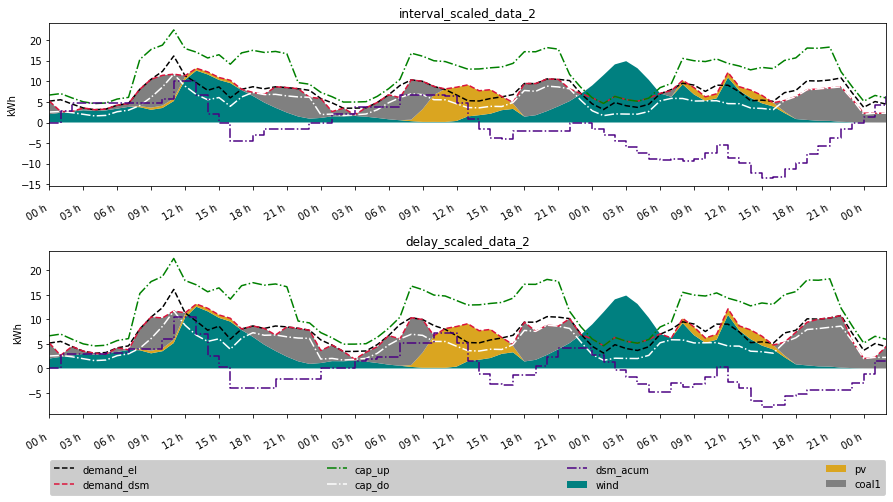

In [16]:
column = ['wind', 'pv', 'coal1']
plots = len([s for s in df_data.keys() if filter_for in s])
fig_all, ax = plt.subplots(max(plots,2),1,figsize=(15,plots*4))

i=0
keys=[]
for _, (key, df) in enumerate(df_data.items()):
    if filter_for in key:
        keys.append(key)
    
        ax[i].set_title(key[:-4])
        
        # area plot generation
        upper = 0
        lower = 0
        for gen, col in enumerate(df[column]):
            upper += df.copy().loc[steps, col]
            upper.name = col
            ax[i].fill_between(steps, lower, upper, step=ds['step'], facecolor=color[gen], label=col)
            lower = upper.copy()

        # plot demand
        ax[i] = df.loc[steps,'demand_el'].plot(ax=ax[i], drawstyle=ds['drawstyle'], style='--', color='black')
        ax[i] = df.loc[steps,'demand_dsm'].plot(ax=ax[i], drawstyle=ds['drawstyle'], style='--', color='crimson')
        
        # calc & plot upper capacity
        cap_up = df.loc[steps,'demand_el'] + df.loc[steps,'cap_up']
        cap_up.name='cap_up'
        ax[i] = cap_up.plot(ax=ax[i], drawstyle=ds['drawstyle'], style='-.', color='green')

        # calc & plot lower capacity
        cap_down = df.loc[steps,'demand_el'] - df.loc[steps,'cap_do']
        cap_down.name='cap_do'
        ax[i] = cap_down.plot(ax=ax[i], drawstyle=ds['drawstyle'], style='-.', color='white')
        
        
        ax[i] = df.loc[steps, 'dsm_acum'].plot(ax=ax[i], drawstyle='steps-post', style='-.', color='indigo')
        
        ax[i].set_ylabel('kWh')
        ax[i].set_xticks(pd.date_range(start=start, periods=timesteps/3, freq='3H', tz=tz))
        ax[i].xaxis.set_minor_locator(mdates.DayLocator(tz = df.index.tz))
        ax[i].xaxis.set_minor_formatter(mdates.DateFormatter('%d.%m', tz=df.index.tz))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('\n%H h', tz=df.index.tz)) 
        ax[i].xaxis.grid(True, which="minor")
        ax[i].xaxis.grid(False, which="major")
        #ax[i].set_facecolor='white'
        
        
        i+=1

handles, labels = ax[i-1].get_legend_handles_labels()
ax[i-1].legend(labels,
             bbox_to_anchor=(0., -.5, 1., .102),
             loc=3, ncol=4,
             mode="expand",
             borderaxespad=0.1,
             facecolor='silver')
fig_all.subplots_adjust(hspace = 0.4)
plt.show()
#fig_all.savefig('./dsm_data_dumps/test/graphics/{}.pdf'.format(filter_for), bbox_inches='tight')

# DSM on hold

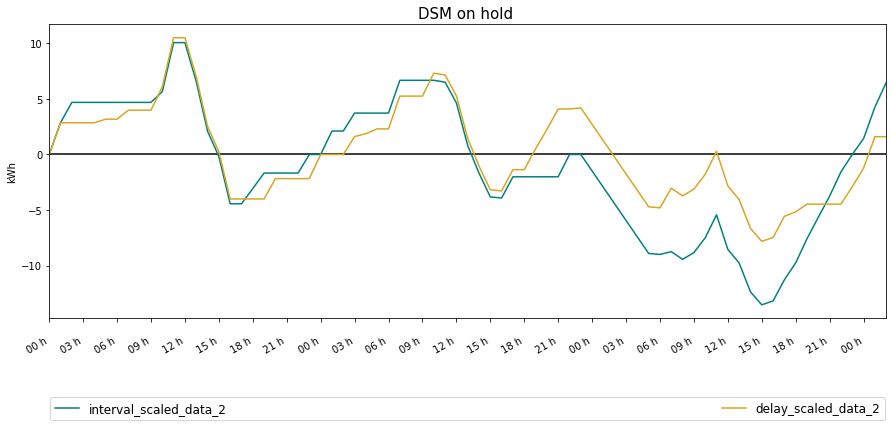

In [17]:
#column = 'demand_dsm'
column = 'dsm_acum'

fig_demand,ax = plt.subplots(figsize=figure_size)
#ax.set_title("{}-----{}".format(column,folder[15:]))
ax.set_title('DSM on hold ', fontsize=15)


# plot demand
#ax = df_data[list(df_data)[0]].loc[steps,'demand_el'].abs().plot(color='black', drawstyle=ds['drawstyle'])

# plot resulting dsm
keys=[]
for i, (key, df) in enumerate(df_data.items()):
    if filter_for in key:
        keys.append(key)
        ax = df.loc[steps,column].plot(ax=ax, drawstyle=ds['drawstyle'], color=color[i] )

#df.loc[steps,'demand_el'].plot(ax=ax, color='black', drawstyle=ds['drawstyle'])
        
ax.set_ylabel('kWh')
ax.set_xticks(pd.date_range(start=start, periods=timesteps/3, freq='3H', tz=tz))
ax.xaxis.set_minor_locator(mdates.DayLocator(tz = df.index.tz))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d.%m', tz=df.index.tz))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%H h', tz=df.index.tz)) 
ax.xaxis.grid(True, which="minor")
ax.xaxis.grid(False, which="major")
ax.hlines(y=0, xmin=start, xmax=end)

handles, _ = ax.get_legend_handles_labels() 
labels = ['{}'.format(keys[:-4])for keys in keys]

#labels.append('demand_el')
ax.legend(labels, bbox_to_anchor=(0., -.35, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.1, fontsize=12)
ax_demand = ax
plt.show()
#fig_demand.savefig('./dsm_model_output/aggregation/dsm_on_hold.pdf', bbox_inches='tight')

## Capacity

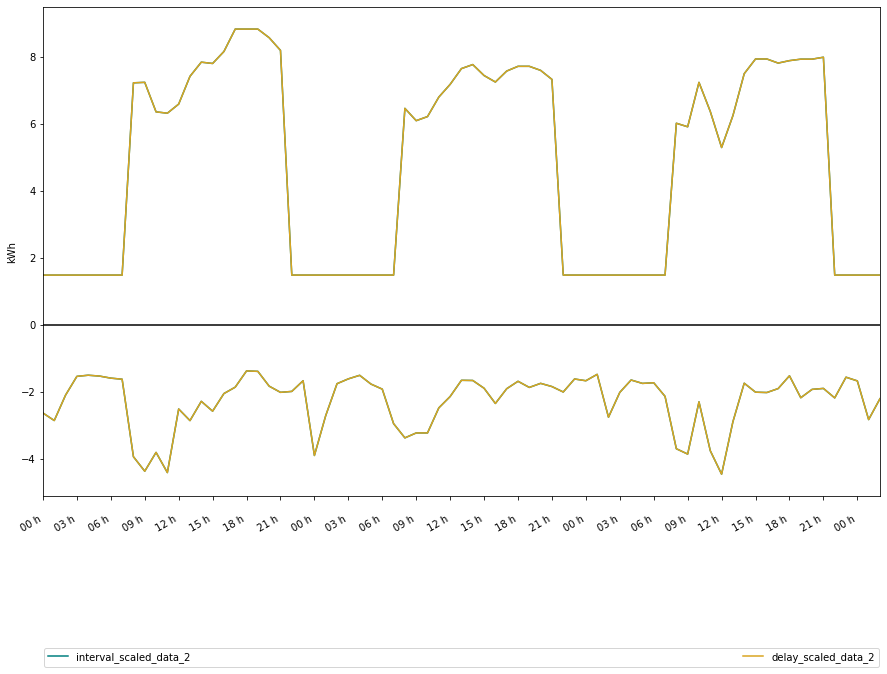

In [18]:
column = ['cap_do','cap_up']

fig_cap, ax = plt.subplots(figsize=(15,10))

#ax.set_title("{}-----{}".format(column,folder[15:]))

keys=[]
for i, (key, df) in enumerate(df_data.items()):
    if filter_for in key:
        keys.append(key)
        (df*-1).loc[steps,'cap_do'].plot(ax=ax, drawstyle=ds['drawstyle'],color=color[i])#, style=style[i])
        
        df.loc[steps,'cap_up'].plot(ax=ax, drawstyle=ds['drawstyle'], color=color[i])#, style=style[i])

        
ax.set_ylabel('kWh')
ax.set_xticks(pd.date_range(start=start, periods=timesteps/3, freq='3H', tz=tz))
ax.xaxis.set_minor_locator(mdates.DayLocator(tz = df.index.tz))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d.%m', tz=df.index.tz))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%H h', tz=df.index.tz)) 
ax.xaxis.grid(True, which="minor")
ax.xaxis.grid(False, which="major")
ax.hlines(y=0, xmin=start, xmax=end)

handles, _ = ax.get_legend_handles_labels()
handles = handles[::2]
labels = ['{}'.format(keys[:-4])for keys in keys]

ax.legend(handles, labels, bbox_to_anchor=(0., -.35, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.1)

ax_cap = ax
plt.show()
